In [1]:
import numpy as np              ;   import pandas as pd
import geopandas as gpd         ;   from shapely.geometry import Polygon, Point, LineString
import shapely as sp            ;   import matplotlib.pyplot as plt
import time                     ;   import unidecode
import re

startAll = time.time()
def t():
    global start
    start = time.time()
def tt():
    end = time.time() ; minutos = int(round(end - start)/60) ; segundos = int(round(end - start)-(int(round(end - start)/60))*60) ;     tiempo = 'Esta celda tardo en ejecutar: '+str(minutos)+' minutos, '+str(segundos)+' segundos.' ;
    return tiempo
def tiempo():
    endAll = time.time() ; minutos = int(round(endAll - startAll)/60) ; segundos = int(round(endAll - startAll)-(int(round(endAll - startAll)/60))*60) ;     tiempo = 'Desde el inicio, tardo en ejecutar: '+str(minutos)+' minutos, '+str(segundos)+' segundos.' ;
    return tiempo


Bad key "text.kerning_factor" on line 4 in
C:\Users\Manu\Anaconda3\envs\manu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# PROPERATTI DATABASE

In [2]:
df = pd.read_csv('properatti.csv',sep=',',index_col=0)
df.shape

(121220, 25)

In [3]:
len(df.place_name.unique())

1061

In [4]:
len(df.property_type.unique())

4

In [5]:
df.head(2)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


# LLAVE UNICA
se encuentra en la direccion URL un codigo embebido que distingue cada registro individualmente

In [6]:
def get_codigo(data):
    data = data.strip('http://www.properati.com.ar/')
    return data.split('_')[0]

In [7]:
df.shape

(121220, 25)

In [8]:
len(df.properati_url.unique())

121220

In [9]:
df['id'] = df.properati_url.map(get_codigo)

In [10]:
len(df.id.unique())

121220

In [11]:
# todos son valores unicos
df.shape[0] == len(df.id.unique())

True

# MISSING DATA

In [12]:
# vemos el total de nulos del dataset
df.isna().sum()[df.isna().sum()>0]

place_name                        23
geonames_id                    18717
lat-lon                        51550
lat                            51550
lon                            51550
price                          20410
currency                       20411
price_aprox_local_currency     20410
price_aprox_usd                20410
surface_total_in_m2            39328
surface_covered_in_m2          19907
price_usd_per_m2               52603
price_per_m2                   33562
floor                         113321
rooms                          73830
expenses                      106958
description                        2
image_thumbnail                 3112
dtype: int64

# MISSING GEO-DATA

In [13]:
# vemos que los faltantes de geolocalización no coinciden, asique hay esperanzas...
df.isna().sum()[df.isna().sum()>0][['place_name','geonames_id','lat-lon','lat','lon']]

place_name        23
geonames_id    18717
lat-lon        51550
lat            51550
lon            51550
dtype: int64

In [14]:
# generamos una columna para luego discriminar las geometrias recibidas de las conseguidas
df['geo_ok'] = 0

for i in range(len(df)):
    if ~np.isnan(df.lat.iloc[i]):
        df.geo_ok.iloc[i] = 1

C:\Users\Manu\Anaconda3\envs\manu\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
# vemos registros sin lat-long pero con geonames_id, recuperaremos ese lat-long
df[df['lat-lon'].isnull()][['place_name','geonames_id','lat-lon','lat','lon']].sample(5)

,place_name,geonames_id,lat-lon,lat,lon
6287,Olivos,3430310.0,NaN,NaN,NaN
33286,Capital Federal,3433955.0,NaN,NaN,NaN
104708,Tigre,3427753.0,NaN,NaN,NaN
66803,Tigre,3427753.0,NaN,NaN,NaN
98063,Rosario,3838574.0,NaN,NaN,NaN


In [16]:
# preparamos los nombres de las columnas segun la documentacion
names = ['geonameid','name','asciiname','alternatenames','latitude','longitude','feature_class','feature_code','country_code','cc2','admin1_code','admin2_code','admin3_code','admin4_code','population','elevation','dem','timezone','modification_date']
# leemos el dataframe
geoNames = pd.read_csv('geonames_id/AR/AR_copia.csv',error_bad_lines=False,sep=';',header=None,names=names)

In [17]:
geoNames.sample(2)

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4_code,population,elevation,dem,timezone,modification_date
35384,3858111,El Durazno,El Durazno,NaN,-29.58333,-63.18333,L,LCTY,AR,NaN,22.0,NaN,NaN,NaN,0,NaN,85,America/Argentina/Cordoba,1993-12-21
24609,3847309,Estancia La Vasconia,Estancia La Vasconia,NaN,-43.80589,-65.41437,S,RNCH,AR,NaN,4.0,26028.0,NaN,NaN,0,NaN,196,America/Argentina/Catamarca,2016-01-30


In [18]:
# testing
geoNames.loc[geoNames.geonameid == 3427458]

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4_code,population,elevation,dem,timezone,modification_date
257,3427458,Villa Crespo,Villa Crespo,"Vilja Krespas,Villa Crespo,ビジャ・クレスポ",-34.60001,-58.44735,P,PPLX,AR,NaN,7.0,2015.0,NaN,NaN,0,NaN,16,America/Argentina/Buenos_Aires,2017-05-08


In [19]:
geoNames.shape

(49677, 19)

In [20]:
len(geoNames.geonameid.unique())

49677

In [21]:
len(geoNames.name.unique())

35223

In [22]:
# diccionario para localizar geoNames con ID
geo_dic_ID = {geoNames.geonameid.iloc[i] : [geoNames.latitude.iloc[i] , geoNames.longitude.iloc[i]] for i in range(len(geoNames))}
# diccionario para localizar geoNames con name
geo_dic_name = {geoNames.name.iloc[i] : [geoNames.latitude.iloc[i] , geoNames.longitude.iloc[i]] for i in range(len(geoNames))}

In [23]:
# en todos los casos que no tenemos lat-lon no tenemos ni lat ni lon...
print('donde falta lat-lon, lat tiene:',df.loc[df['lat-lon'].isnull()].lat.unique()) ; print('donde falta lat-lon, lon tiene:',df.loc[df['lat-lon'].isnull()].lon.unique())
print('')
# en todos los casos que no tenemos lat ni lon no tenemos lat-lon...
print('donde falta lat, lat-lon tiene:',df.loc[df['lat'].isnull()]['lat-lon'].unique()) ; print('donde falta lon, lat-lon tiene:',df.loc[df['lon'].isnull()]['lat-lon'].unique())

donde falta lat-lon, lat tiene: [nan]
donde falta lat-lon, lon tiene: [nan]

donde falta lat, lat-lon tiene: [nan]
donde falta lon, lat-lon tiene: [nan]


### podemos pisar informacion segun ID

In [24]:
# donde falte lat, corremos nuestro dic de ids
for i in range(len(df)):
    try:
        if np.isnan(df.lat.iloc[i]):
            df.lat.iloc[i] = geo_dic_ID[df.geonames_id.iloc[i]][0]
            df.lon.iloc[i] = geo_dic_ID[df.geonames_id.iloc[i]][1]
    except:
        pass

C:\Users\Manu\Anaconda3\envs\manu\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
# baja el numero de 51550 a 8346
df.isna().sum()[df.isna().sum()>0][['geonames_id','lat-lon','lat','lon']]

geonames_id    18717
lat-lon        51550
lat             8346
lon             8346
dtype: int64

In [26]:
# vemos registros sin lat-long pero con geonames_id, recuperaremos ese lat-long
df.loc[df['lat'].isnull()].loc[df['geonames_id'].isnull()][['place_name','geonames_id','lat-lon','lat','lon']].sample(5)

,place_name,geonames_id,lat-lon,lat,lon
90846,Adrogué,NaN,NaN,NaN,NaN
33686,Nordelta,NaN,NaN,NaN,NaN
73195,Mayling Club de Campo,NaN,NaN,NaN,NaN
70064,Guernica,NaN,NaN,NaN,NaN
64261,Nordelta,NaN,NaN,NaN,NaN


### podemos pisar informacion segun place_name

In [27]:
# donde falte lat, corremos nuestro dic de names
for i in range(len(df)):
    try:
        if np.isnan(df.lat.iloc[i]):
            df.lat.iloc[i] = geo_dic_name[df.place_name.iloc[i]][0]
            df.lon.iloc[i] = geo_dic_name[df.place_name.iloc[i]][1]
    except:
        pass

C:\Users\Manu\Anaconda3\envs\manu\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
# baja el numero de 8346 a 2017
df.isna().sum()[df.isna().sum()>0][['geonames_id','lat-lon','lat','lon']]

geonames_id    18717
lat-lon        51550
lat             2017
lon             2017
dtype: int64

# GEONAMES by parent NAME
aun quedan 2017 valores por hallar, se sospecha que las ciudades no están escritas de la misma manera


In [29]:
falta_geo = df[df['lat'].isna()][['place_with_parent_names','place_name']]

In [30]:
falta_geo.reset_index(inplace=True)

In [31]:
falta_geo.sample(3)

,index,place_with_parent_names,place_name
1041,86145,|Argentina|Capital Federal|Palermo|Palermo Chico|,Palermo Chico
1157,91669,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Caisamar
1360,94393,|Argentina|Bs.As. G.B.A. Zona Sur|Lanús|Valent...,Valentín Alsina


In [32]:
falta_geo.place_with_parent_names = [falta_geo.place_with_parent_names.iloc[i].strip('|') for i in range(len(falta_geo))]

In [33]:
cant_pipes = []

for i in range(len(falta_geo)):
    cant_pipes.append(len(falta_geo.place_with_parent_names.iloc[i].split('|')))

set(cant_pipes)

{2, 3, 4, 5}

### duplicamos falta_geo para acortar

In [34]:
fg = falta_geo

In [35]:
cols = ['or1','or2','or3','or4','or5']

In [36]:
fg['or1'],fg['or2'],fg['or3'],fg['or4'],fg['or5'] = '','','','',''

In [37]:
for i in range(len(fg)):
    for x, y in enumerate(cols,0):
        try:
            fg[y].iloc[i] = fg.place_with_parent_names.iloc[i].split('|')[x]
        except: pass

C:\Users\Manu\Anaconda3\envs\manu\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
fg['lat'] = np.nan
fg['lon'] = np.nan
fg['coincide_con'] = np.nan

np.random.seed(3)
fg.sample(5)

,index,place_with_parent_names,place_name,or1,or2,or3,or4,or5,lat,lon,coincide_con
1900,108297,Argentina|Bs.As. G.B.A. Zona Norte|Tigre|La Co...,La Comarca,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,La Comarca,,NaN,NaN,NaN
818,79088,Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Solar...,Solares del Talar,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Solares del Talar,,NaN,NaN,NaN
400,51806,Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|...,Boulogne Sur Mer,Argentina,Bs.As. G.B.A. Zona Norte,San Isidro,Boulogne Sur Mer,,NaN,NaN,NaN
1285,93866,Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Norde...,Enyoi,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,Enyoi,NaN,NaN,NaN
1831,106556,Argentina|Bs.As. G.B.A. Zona Sur|La Plata|Manu...,Manuel B Gonnet,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,Manuel B Gonnet,,NaN,NaN,NaN


In [39]:
cols.reverse()

In [40]:
fg.head(3)

,index,place_with_parent_names,place_name,or1,or2,or3,or4,or5,lat,lon,coincide_con
0,109,Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|...,Boulogne Sur Mer,Argentina,Bs.As. G.B.A. Zona Norte,San Isidro,Boulogne Sur Mer,,NaN,NaN,NaN
1,581,Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Norde...,Enyoi,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,Enyoi,NaN,NaN,NaN
2,584,Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Norde...,Enyoi,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,Enyoi,NaN,NaN,NaN


In [41]:
for x, y in enumerate(cols,0):
    print(x)
    print(y)

0
or5
1
or4
2
or3
3
or2
4
or1


In [42]:
temp = fg.head()

In [43]:
geo_dic_name['San Isidro']

[-22.26667, -66.16667]

In [44]:
geo_dic_name[temp.or3.iloc[0]]

[-22.26667, -66.16667]

In [45]:
for i in range(5):
    for x in cols:
        try:
            print(fg[x].iloc[i], geo_dic_name[fg[x].iloc[i]])
        except:pass

San Isidro [-22.26667, -66.16667]
Argentina [-29.535320000000002, -62.26693]
Nordelta [-34.41427, -58.651709999999994]
Tigre [-22.383329999999997, -63.85]
Argentina [-29.535320000000002, -62.26693]
Nordelta [-34.41427, -58.651709999999994]
Tigre [-22.383329999999997, -63.85]
Argentina [-29.535320000000002, -62.26693]
Tigre [-22.383329999999997, -63.85]
Argentina [-29.535320000000002, -62.26693]
Tigre [-22.383329999999997, -63.85]
Argentina [-29.535320000000002, -62.26693]


In [46]:
for i in range(len(fg)):
    for x in cols:
        try:
            fg.lat.iloc[i] = geo_dic_name[fg[x].iloc[i]][0]
            fg.lon.iloc[i] = geo_dic_name[fg[x].iloc[i]][1]
            fg.coincide_con.iloc[i] = fg[x].iloc[i]
            break # por no cortar el loop cuando encontraba una coincidencia, terminaba poniendo todos Argentina
        except: pass

C:\Users\Manu\Anaconda3\envs\manu\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [47]:
new_geo_dic = {fg['index'].iloc[i] : [fg.lat.iloc[i],fg.lon.iloc[i]] for i in range(len(fg))}

In [48]:
df.index[2]

2

In [49]:
# donde falte lat, corremos nuestro dic de names
for i in range(len(df)):
    try:
        if np.isnan(df.lat.iloc[i]):
            df.lat.iloc[i] = new_geo_dic[df.index[i]][0]
            df.lon.iloc[i] = new_geo_dic[df.index[i]][1]
    except:
        pass

In [50]:
# volvemos a comprobar los faltantes
df.isna().sum()[['lat','lon']]

lat    0
lon    0
dtype: int64

# correcta o no, ya tenemos todas las geolocalizacioens

# GEOLOCALIZACION

In [51]:
geodf = gpd.GeoDataFrame(df)

In [52]:
geodf = geodf.loc[geodf.lat.notna()]

In [53]:
geodf.reset_index(drop=True,inplace=True)

In [54]:
t()
geodf['geometry'] = geodf.index.map(lambda x: Point(geodf.lon.iloc[x],geodf.lat.iloc[x]))
tt()

'Esta celda tardo en ejecutar: 0 minutos, 6 segundos.'

# MAPA Argentina

In [55]:
# # ENCONTRE UN MAPA EMBEBIDO EN PANDAS, PERO NO COINCIDE 100%, NO LO USO
# mundo = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# argentina2 = mundo.loc[mundo.name == 'Argentina']

In [56]:
# leo una cartografia de fondo
mapBase = gpd.read_file('Codgeo/pxdptodatosok.shp')

In [57]:
def acentos(data):
    try:         return data.replace('Ã³','ó').replace('Ã¡','á').replace('Ã­','í').replace('Ã©','e').replace('Ãº','ú')
    except:      pass

mapBase.departamen = mapBase.departamen.map(acentos)
mapBase.provincia = mapBase.provincia.map(acentos)
# quitamos la antartida
mapBase = mapBase.loc[(mapBase.departamen != 'Antártida Argentina')&(mapBase.departamen != 'Islas del Atlántico Sur')]

In [58]:
simple = mapBase[['codpcia','departamen','provincia','geometry']]
mas_simple = mapBase[['codpcia','provincia']]
lista_codigos = mas_simple.drop_duplicates()

In [59]:
dic_codigos = {lista_codigos.codpcia.iloc[i] : lista_codigos.provincia.iloc[i] for i in range(len(lista_codigos))}

In [60]:
a = dic_codigos['02']
a

'Ciudad Autónoma de Buenos Aires'

In [61]:
# recortamos las provincias
provincias = mapBase.dissolve('codpcia')
provincias = provincias.reindex(['pais','provincia','geometry'],axis=1)
provincias['pais'] = 'Agentina'
argentina = provincias.dissolve('pais')

#recortamos el mapa de buenos aires del total argentino
capitalMap = simple.loc[simple.codpcia == '02', :]
gbaMap = simple.loc[simple.codpcia == '06', :]
bsasMap = capitalMap.append(gbaMap, ignore_index=True)

#estandarizamos nuestros index y eliminamos las columnas q no usaremos
capital = capitalMap.reset_index()
gbaMap = gbaMap.reset_index()
bsasMap = bsasMap.reset_index()

### en primera instancia vemos algunos puntos fuera de argentina.

In [62]:
geodf.crs = argentina.crs

In [63]:
geodf.columns

Index(['operation', 'property_type', 'place_name', 'place_with_parent_names',
       'country_name', 'state_name', 'geonames_id', 'lat-lon', 'lat', 'lon',
       'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'properati_url',
       'description', 'title', 'image_thumbnail', 'id', 'geo_ok', 'geometry'],
      dtype='object')

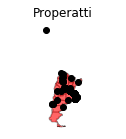

In [64]:
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(1,1,1)

provincias.plot(ax=ax,alpha=0.4,color='white',edgecolor='black')
argentina.plot(ax=ax,alpha=0.6,color='red')
#ploteamos el valor que ya sabemos erroneo
geodf.loc[[9761]].plot(ax=ax,color='black')
# y una muestra de algunos otros, para que no demore
geodf.sample(200).plot(ax=ax,color='black')

ax.set_axis_off()
plt.axis('equal')
ax.set_title('Properatti');

# queda un punto fuera

In [65]:
#conseguimos el index del error
error = geodf.loc[geodf.lat == geodf.lat.max()].index[0]
geodf.loc[geodf.lat == geodf.lat.max()][['place_name','geonames_id','lat','lon']]

,place_name,geonames_id,lat,lon
9761,Córdoba,3860255.0,4.545843,-75.678931


In [66]:
# vemos un error de coordenadas
geodf.lat.iloc[error] = geo_dic_ID[geodf.loc[error].geonames_id][0]
geodf.lon.iloc[error] = geo_dic_ID[geodf.loc[error].geonames_id][1]

# volvemos a generar ese punto
geodf['geometry'].iloc[error] = Point(geodf.lon.iloc[error],geodf.lat.iloc[error])

C:\Users\Manu\Anaconda3\envs\manu\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


'Esta celda tardo en ejecutar: 0 minutos, 6 segundos.'

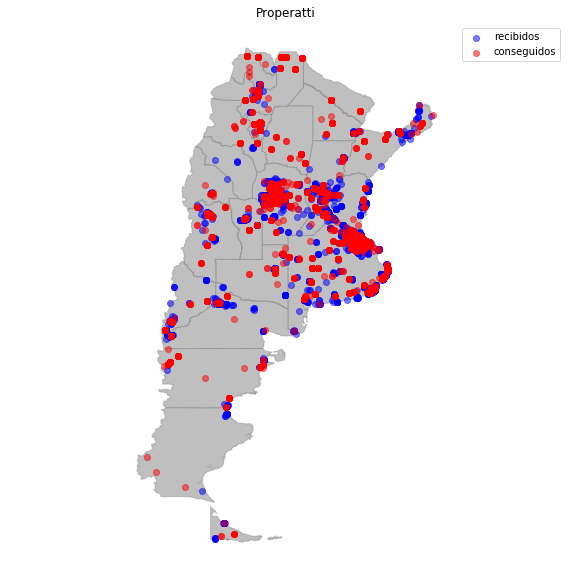

In [67]:
t()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

provincias.plot(ax=ax,alpha=0.4,color='white',edgecolor='grey')
argentina.plot(ax=ax,alpha=0.5,color='grey')

# ploteamos en verde los que vinieron en el dataframe
geodf.loc[geodf.geo_ok == 1].plot(ax=ax,color='blue',alpha=0.5)

# ploteamos en amarillo los que conseguimos nosotros los que vinieron en el dataframe
geodf.loc[geodf.geo_ok == 0].plot(ax=ax,color='red',alpha=0.5)

ax.legend({'recibidos':'blue','conseguidos':'red'})
ax.set_axis_off()
plt.axis('equal')
ax.set_title('Properatti');
tt()

In [68]:
tiempo()

'Desde el inicio, tardo en ejecutar: 1 minutos, 15 segundos.'

# ploteo con forloop

In [69]:
# # demora 2 minutos 15

# t() ; fig = plt.figure(figsize=(10,10)) ; ax = fig.add_subplot(1,1,1)

# toplot = geodf[['geo_ok','geometry']] ; sample = 100

# provincias.plot(ax=ax,alpha=0.4,color='white',edgecolor='grey') ; argentina.plot(ax=ax,alpha=0.5,color='grey')
# x = toplot.loc[toplot.geo_ok==1].sample(toplot.geo_ok.value_counts()[1]-10000)
# toplot = toplot.drop(list(x.index)) ; x.plot(ax=ax,color='blue')
# x = toplot.loc[toplot.geo_ok==0].sample(toplot.geo_ok.value_counts()[0]-10000)
# toplot = toplot.drop(list(x.index)) ; x.plot(ax=ax,color='red')

# # ploteamos con un forloop para que se entremezclen los puntos
# while len(toplot) >0 :
#     # establecemos una condicion de modo tal que si el df llega a 0 len se interrumpe el loop
#     if len(toplot) == 0:         break
    
#     try:
#         x = toplot.loc[toplot.geo_ok==0].sample(sample)
#         toplot = toplot.drop(list(x.index))
#         x.plot(ax=ax,color='red')
#     except: pass
#     try:
#         x = toplot.loc[toplot.geo_ok==1].sample(sample)
#         toplot = toplot.drop(list(x.index))
#         x.plot(ax=ax,color='blue')
#     except: pass

# ax.legend({'recibidos':'blue','conseguidos':'red'}) ; ax.set_axis_off() ; plt.axis('equal')
# ax.set_title('Properatti');
# tt()

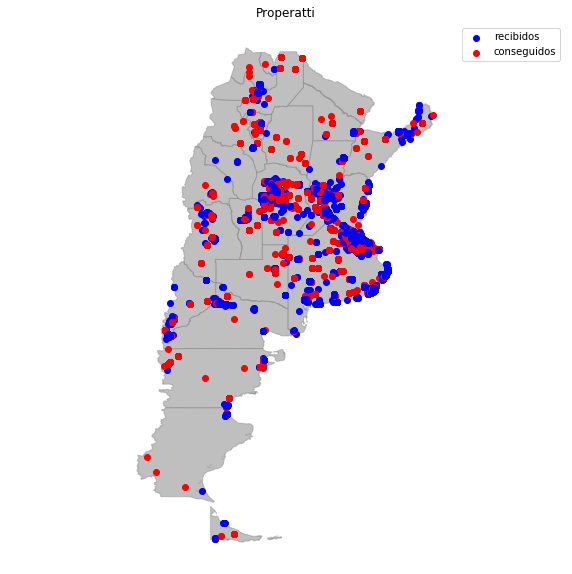

In [70]:
tiempo()

'Desde el inicio, tardo en ejecutar: 1 minutos, 15 segundos.'

# comprobamos que todos queden dentro de Argentina

In [71]:
t() # este proceso demora bastante: 3 minutos
# ya obtuvimos este resultado por lo que no es necesario correrlo siempre

# coincidencia = gpd.sjoin(geodf,argentina,how='inner')
tt()

# print(len(geodf) - len(coincidencia),'puntos fuera de argentina.')

'Esta celda tardo en ejecutar: 0 minutos, 0 segundos.'

In [72]:
'72 puntos fuera de argentina.'

'72 puntos fuera de argentina.'

# fuera de Argentina

In [73]:
# index_coincidentes = list(coincidencia.index)

# geo_ok = coincidencia[['id','geometry']]

# geodf_total = geodf[['id','geometry']]

# fuera_arg = pd.concat([geodf_total,geo_ok])

# # finalmente quitamos los duplicados y obtenemos los puntos que se encuentran fuera del mapa de Argentina
# fuera_arg.drop_duplicates(keep=False,inplace=True)

In [74]:
# anteriormente hemos obtenido esta lista, pero para dejar de correr esos largos procesos, la establecemos aquí.
fuera_list = [667, 5139, 12197, 12411, 13448, 13931, 14155, 14157, 15870, 16837, 17031, 22161, 22214, 22376, 22377, 22393, 23624, 24630, 28629, 29477, 30126, 31616, 31618, 32533, 33830, 34803, 35176, 35614, 36874, 39841, 39860, 39871, 43280, 46036, 46739, 48370, 51958, 53376, 53641, 54688, 56423, 56425, 56430, 56996, 57752, 58489, 58904, 59204, 60303, 60771, 60773, 61498, 61506, 62637, 63511, 66455, 69329, 74403, 79179, 79250, 88816, 93480, 93939, 97685, 97788, 97793, 97888, 100043, 109690, 119569, 119830, 121139]

In [75]:
fuera_arg = geodf.loc[fuera_list]

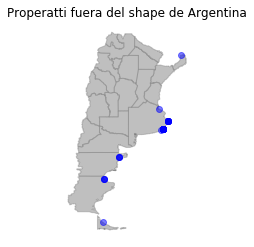

In [76]:
fig = plt.figure(figsize=(4,4)) ; ax = fig.add_subplot(1,1,1)

provincias.plot(ax=ax,alpha=0.4,color='white',edgecolor='grey')
argentina.plot(ax=ax,alpha=0.5,color='grey')
# ploteamos en verde los que vinieron en el dataframe
fuera_arg.plot(ax=ax,color='blue',alpha=0.5)

ax.set_axis_off() ; plt.axis('equal')
ax.set_title('Properatti fuera del shape de Argentina');

In [77]:
# creamos un dic para obtener las procinvias de dichos puntos
dic_registro_id = {df.id.iloc[i] : df.state_name.iloc[i] for i in range(len(df))}

In [78]:
fuera_arg.reset_index(inplace=True)

fuera_arg['prov'] = fuera_arg.id.map(dic_registro_id)

# normalizamos algunos nombres
fuera_arg.prov = fuera_arg.prov.replace('Buenos Aires Costa Atlántica','Buenos Aires')\
                               .replace('Bs.As. G.B.A. Zona Sur','Buenos Aires')\
                               .replace('Tierra Del Fuego','Tierra del Fuego')

In [79]:
prov_fuera_arg = fuera_arg.prov.unique()
prov_fuera_arg

array(['Buenos Aires', 'Chubut', 'Santa Cruz', 'Tierra del Fuego',
       'Misiones'], dtype=object)

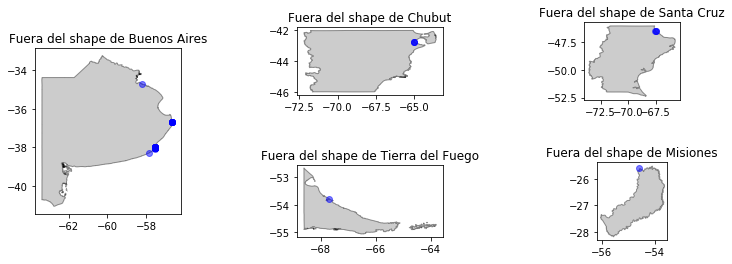

In [80]:
fig= plt.subplots(figsize=(12,4))

# para i, el elemento de la lista de provincias y para e una lista de subplots ya definidos
for i,e in enumerate([131,232,233,235,236]):
    
    ax = plt.subplot(e)   # en grilla de 1x3 ocupa el espacio 1
    prov = prov_fuera_arg[i]
    provincias.loc[provincias.provincia == prov].plot(ax=ax, alpha=0.4,color='grey',edgecolor='black')
    fuera_arg.loc[fuera_arg.prov == prov].plot(ax=ax, color='blue',alpha=0.5)
    ax.set_title('Fuera del shape de {}'.format(prov));

plt.subplots_adjust(hspace=0.8,wspace=0.8)

In [81]:
tiempo()

'Desde el inicio, tardo en ejecutar: 1 minutos, 22 segundos.'

In [82]:
'Desde el inicio, tardo en ejecutar: 2 minutos, 53 segundos.'

'Desde el inicio, tardo en ejecutar: 2 minutos, 53 segundos.'

# analisis de un caso fuera de argentina
los que caen fuera de argentina están sobre los márgenes, asique entendemos se debe a una diferencia minuscula

In [84]:
prov = 'Misiones'

In [85]:
lat = fuera_arg.loc[fuera_arg.prov == prov].lat.max(); print('lat',lat)
lon = fuera_arg.loc[fuera_arg.prov == prov].lon.min(); print('lon',lon)

lat -25.59477425
lon -54.5848999


In [86]:
distance = 0.05
lat_low = lat - distance ; lat_upe = lat + distance ; lon_low = lon - distance ; lon_upe = lon + distance

In [87]:
test = Polygon([ (lon_upe,lat_upe), (lon_upe,lat_low), (lon_low,lat_low), (lon_low,lat_upe) ],)
dbperimetro = gpd.GeoDataFrame({'geometry':[test]})
dbperimetro.crs = provincias.crs

In [88]:
misiones = provincias.loc[provincias.provincia == 'Misiones']
temp = gpd.sjoin(misiones[['geometry']],dbperimetro[['geometry']], op='intersects')
temp

,geometry,index_right
54,"POLYGON ((-55.31861 -27.91788, -55.31861 -27.9...",0


In [89]:
recorte = gpd.overlay(misiones, dbperimetro, how='intersection')

Text(0.5, 1, 'Fuera de Misiones')

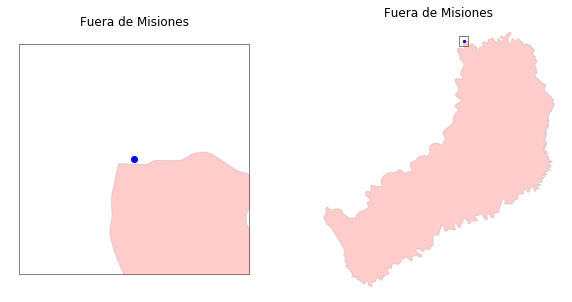

In [90]:
fig = plt.figure(figsize=(10,5)) ; 

ax = fig.add_subplot(1,2,1)
dbperimetro.plot(ax=ax,edgecolor='grey',facecolor='white')
recorte.plot(ax=ax,alpha=0.2,color='red',edgecolor='grey')
fuera_arg.loc[fuera_arg.prov == prov].plot(ax=ax, color='blue')

ax1 = fig.add_subplot(1,2,2)
dbperimetro.plot(ax=ax1,edgecolor='grey',facecolor='white')
misiones.plot(ax=ax1,alpha=0.2,color='red',edgecolor='grey')
fuera_arg.loc[fuera_arg.prov == prov].plot(ax=ax1, color='blue',markersize=5)

ax.set_axis_off()
ax1.set_axis_off()
plt.axis('equal')
ax.set_title('Fuera de {}'.format(prov))
ax1.set_title('Fuera de {}'.format(prov))

In [91]:
tiempo()

'Desde el inicio, tardo en ejecutar: 1 minutos, 24 segundos.'

In [93]:
fuera_arg.loc[fuera_arg.prov == prov]

,index,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,rooms,expenses,properati_url,description,title,image_thumbnail,id,geo_ok,geometry,prov
46,58904,sell,apartment,Puerto Iguazú,|Argentina|Misiones|Puerto Iguazú|,Argentina,Misiones,3429777.0,"-25.59477425,-54.5848999",-25.594774,...,NaN,NaN,http://www.properati.com.ar/19wgq_venta_depart...,JMF Excelente Suite Estándar en Condo Hotel 3...,JMF Habitación en Hotel Merit Iguazú,https://thumbs4.properati.com/8/cKsD8K-ANRznq6...,19wgq,1,POINT (-54.58490 -25.59477),Misiones


# poner cada punto sobre la geometria mas cercana